In [1]:
import pandas as pd
from copy import deepcopy
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import gpplot
from scipy.stats import yeojohnson, rankdata
from sklearn.base import clone
import numpy as np
from sklearn import preprocessing
import warnings
import matplotlib
from tqdm import tqdm
from scipy.stats import mannwhitneyu

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
def perform_mannwhitney_tests(chrtest, gene_col, phenotype):
    results = []
    # Get unique values from the specified columns
    experiment_seq = chrtest['ATACseq'].unique()
    DataSet = chrtest['DataSet'].unique()
    Domain = chrtest['Domain'].unique()

    # Iterate over the combinations of parameters
    for experiment in tqdm(experiment_seq):
        
        for data in tqdm(DataSet):
            if data == 'InHouse':
                alter = 'greater'
            elif data == 'Nunez':
                alter = 'greater'
            elif data == 'Gilbert':
                alter = 'less' 
            for krab in tqdm(Domain):
                    chrtest_subset = chrtest[(chrtest['ATACseq'] == experiment) & 
                                             (chrtest['Domain'] == krab) & 
                                             (chrtest['DataSet'] == data) ]
                    for gene in chrtest_subset[gene_col].unique():
                        gene_sp = chrtest_subset[chrtest_subset[gene_col] == gene]
                        binary_col = 'overlap with peak'
                        if (sum(gene_sp[binary_col] == 1) >= 10) & (sum(gene_sp[binary_col] == 0) >= 10):
                            _, pval = mannwhitneyu(gene_sp[gene_sp[binary_col] == 0][phenotype], 
                                                   gene_sp[gene_sp[binary_col] == 1][phenotype], 
                                                   alternative=alter, method="asymptotic")
                            results.append({
                                'ATACseq': experiment,
                                'DataSet': data,
                                'Domain': krab,
                                'gene': gene,
                                'pval': pval
                            })
                        else:
                            print(f"{gene}: Sample size in overlap or non-overlap < 10")
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df


In [3]:
dataOut = '../../../../data/2024/Manuscript/CleanedScaledData/'
GilbertRicinScaledData = pd.read_csv(dataOut+'GilbertRicinScaledData.csv')
inHouseZim3ScaledData = pd.read_csv(dataOut+'inHouseZim3ScaledData.csv')
inHouseKox1ScaledData = pd.read_csv(dataOut+'inHouseKox1ScaledData.csv')
nunezScaledData = pd.read_csv(dataOut+'nunezScaledData.csv')


In [4]:
combinedData = pd.concat([nunezScaledData, inHouseKox1ScaledData, inHouseZim3ScaledData, GilbertRicinScaledData])

In [5]:
# ess gene
ess_noness = pd.read_csv('../Data/PrimaryLibrary/design/essentials_nonessentials_CRISPRi_tiling_designs_v2.csv')
EssGene = ess_noness[ess_noness.Category == 'Essential']['Target Gene Symbol'].unique()
# atac
atac_path = '../Data/ATACseq/'
ATAC_combined = pd.read_csv(atac_path + 'ATACseqPeakOverlap_v2.csv')

# only guide with phenotype
InhouseEssATAC = ATAC_combined[(ATAC_combined.DataSet == 'InHouse') & (ATAC_combined['Target Gene Symbol'].isin(EssGene))]
otherATAC = ATAC_combined[~(ATAC_combined.DataSet == 'InHouse')]
newATAC = pd.concat([InhouseEssATAC,otherATAC])

newATAC[['condition', 'Domain', 'DataSet','ATACseq']].value_counts()

condition  Domain  DataSet  ATACseq
K562       Kox1    Nunez    Panc1      68575
                            MCF7       68575
                            K562       68575
                            HepG2      68575
                            HCT116     68575
                            GM12878    68575
                            A549       68575
HCT116     Kox1    InHouse  A549       42609
                            MCF7       42609
                            K562       42609
                            HepG2      42609
                            HCT116     42609
                            GM12878    42609
A549       Zim3    InHouse  HepG2      42609
                            Panc1      42609
                            MCF7       42609
                            K562       42609
                            HCT116     42609
                            GM12878    42609
                            A549       42609
HCT116     Kox1    InHouse  Panc1      42609
A549       Kox1    

In [6]:
newATAC

,Target Gene Symbol,chromosome,sgRNA Context Sequence,condition,Domain,DataSet,overlap with peak,orginal phenotype,ATACseq
609616,LARS2,chr3,CAGAAAAAAAAAAACAGGACACAGGGGAGA,A549,Kox1,InHouse,1,-0.398339,K562
609617,LARS2,chr3,CAGAAAAAAAAAAACAGGACACAGGGGAGA,A549,Kox1,InHouse,0,-0.398339,HCT116
609618,LARS2,chr3,CAGAAAAAAAAAAACAGGACACAGGGGAGA,A549,Kox1,InHouse,1,-0.398339,A549
609619,LARS2,chr3,CAGAAAAAAAAAAACAGGACACAGGGGAGA,A549,Kox1,InHouse,0,-0.398339,MCF7
609620,LARS2,chr3,CAGAAAAAAAAAAACAGGACACAGGGGAGA,A549,Kox1,InHouse,0,-0.398339,Panc1
...,...,...,...,...,...,...,...,...,...
609583,WDR11,chr10,GAAATAAAAGCTCCAGAAATGCCAAGGGGC,K562,Kox1,Gilbert,0,-0.021742,A549
609584,WDR11,chr10,GAAATAAAAGCTCCAGAAATGCCAAGGGGC,K562,Kox1,Gilbert,0,-0.021742,MCF7
609585,WDR11,chr10,GAAATAAAAGCTCCAGAAATGCCAAGGGGC,K562,Kox1,Gilbert,0,-0.021742,Panc1
609586,WDR11,chr10,GAAATAAAAGCTCCAGAAATGCCAAGGGGC,K562,Kox1,Gilbert,0,-0.021742,HepG2


In [7]:
len(nunezScaledData)

68575

In [8]:
len(GilbertRicinScaledData)


18509

In [9]:
len(inHouseZim3ScaledData)


42104

In [10]:
len(inHouseKox1ScaledData)

42104

In [11]:
shortenNewATAC = newATAC[['Target Gene Symbol', 'chromosome', 'sgRNA Context Sequence',
     'Domain', 'DataSet',
      'overlap with peak', 'ATACseq']].drop_duplicates().copy()

In [12]:
shortenNewATAC[['Domain', 'DataSet', 'ATACseq']].value_counts()
# more datapoint in Zim3 InHouse because we are taking the union of two cell lines

Domain  DataSet  ATACseq
Kox1    Nunez    A549       68575
                 GM12878    68575
                 Panc1      68575
                 MCF7       68575
                 K562       68575
                 HepG2      68575
                 HCT116     68575
Zim3    InHouse  MCF7       42762
                 K562       42762
                 HepG2      42762
                 HCT116     42762
                 GM12878    42762
                 A549       42762
                 Panc1      42762
Kox1    InHouse  Panc1      42761
                 MCF7       42761
                 K562       42761
                 HepG2      42761
                 HCT116     42761
                 GM12878    42761
                 A549       42761
        Gilbert  GM12878    18509
                 Panc1      18509
                 MCF7       18509
                 K562       18509
                 HepG2      18509
                 HCT116     18509
                 A549       18509
dtype: int64

In [13]:
combinedData[['Domain', 'DataSet']].value_counts()

Domain  DataSet
Kox1    Nunez      68575
        InHouse    42104
Zim3    InHouse    42104
Kox1    Gilbert    18509
dtype: int64

In [14]:
shortenNewATAC['sgRNA Context Sequence'] = shortenNewATAC['sgRNA Context Sequence'].str.upper()
combinedData['sgRNA Context Sequence'] = combinedData['sgRNA Context Sequence'].str.upper()

In [15]:
combinedDataATAC = pd.merge(shortenNewATAC,combinedData, how = 'inner',
                           on = ['Target Gene Symbol',
                                 'sgRNA Context Sequence',
                                 'Domain', 'DataSet'])


In [16]:
combinedDataATAC[['Domain', 'DataSet', 'ATACseq']].value_counts()

Domain  DataSet  ATACseq
Kox1    Nunez    A549       68575
                 GM12878    68575
                 Panc1      68575
                 MCF7       68575
                 K562       68575
                 HepG2      68575
                 HCT116     68575
Zim3    InHouse  MCF7       42104
                 K562       42104
                 HepG2      42104
                 HCT116     42104
                 GM12878    42104
                 A549       42104
                 Panc1      42104
Kox1    InHouse  Panc1      42104
                 MCF7       42104
                 K562       42104
                 HepG2      42104
                 HCT116     42104
                 GM12878    42104
                 A549       42104
        Gilbert  GM12878    18509
                 Panc1      18509
                 MCF7       18509
                 K562       18509
                 HepG2      18509
                 HCT116     18509
                 A549       18509
dtype: int64

In [17]:
combinedDataATAC.head(3)

,Target Gene Symbol,chromosome,sgRNA Context Sequence,Domain,DataSet,overlap with peak,ATACseq,doubleZscore
0,COPS3,chr17,AAAAAAAAAAAAAGCCGTGTGAGCTGGCGG,Kox1,InHouse,1,K562,0.261777
1,COPS3,chr17,AAAAAAAAAAAAAGCCGTGTGAGCTGGCGG,Kox1,InHouse,0,HCT116,0.261777
2,COPS3,chr17,AAAAAAAAAAAAAGCCGTGTGAGCTGGCGG,Kox1,InHouse,1,A549,0.261777


In [18]:
atacPath = '../Data/CleanedScaledData/ATAC/'
combinedDataATAC.to_csv(atacPath+'ATACwithScaledData.csv', index = False)

In [19]:
results_df = perform_mannwhitney_tests(combinedDataATAC, 'Target Gene Symbol', 'doubleZscore')


  0%|                                                                                                                                                              | 0/3 [00:00<?, ?it/s]

  0%|                                                                                                                                                              | 0/2 [00:00<?, ?it/s]

KDSR: Sample size in overlap or non-overlap < 10
BRIX1: Sample size in overlap or non-overlap < 10
CEBPE: Sample size in overlap or non-overlap < 10
ATIC: Sample size in overlap or non-overlap < 10




 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:00<00:00,  1.22it/s]

KDSR: Sample size in overlap or non-overlap < 10
BRIX1: Sample size in overlap or non-overlap < 10
CEBPE: Sample size in overlap or non-overlap < 10
ATIC: Sample size in overlap or non-overlap < 10




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.22it/s]

 33%|██████████████████████████████████████████████████                                                                                                    | 1/3 [00:01<00:03,  1.65s/it]

  0%|                                                                                                                                                              | 0/2 [00:00<?, ?it/s]

CARF: Sample size in overlap or non-overlap < 10
COPB2: Sample size in overlap or non-overlap < 10
CWF19L2: Sample size in overlap or non-overlap < 10
DBR1: Sample size in overlap or non-overlap < 10
DDX21: Sample size in overlap or non-overlap < 10
EIF3A: Sample size in overlap or non-overlap < 10
EIF3M: Sample size in overlap or non-overlap < 10
FBL: Sample size in overlap or non-overlap < 10
LEO1: Sample size in overlap or non-overlap < 10
MDN1: Sample size in overlap or non-overlap < 10
MED18: Sample size in overlap or non-overlap < 10
MRPS35: Sample size in overlap or non-overlap < 10
MYBL2: Sample size in overlap or non-overlap < 10
NIP7: Sample size in overlap or non-overlap < 10
NLE1: Sample size in overlap or non-overlap < 10
POLR1B: Sample size in overlap or non-overlap < 10
SCFD1: Sample size in overlap or non-overlap < 10
SNW1: Sample size in overlap or non-overlap < 10
STAT5B: Sample size in overlap or non-overlap < 10
SUPV3L1: Sample size in overlap or non-overlap < 10




 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:01<00:01,  1.96s/it]

VPS54: Sample size in overlap or non-overlap < 10




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.07s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2/3 [00:03<00:01,  1.95s/it]

  0%|                                                                                                                                                              | 0/2 [00:00<?, ?it/s]

 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:00<00:00,  3.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.21it/s]

  0%|                                                          

KDSR: Sample size in overlap or non-overlap < 10
CEBPE: Sample size in overlap or non-overlap < 10
ATIC: Sample size in overlap or non-overlap < 10




 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:00<00:00,  1.22it/s]

KDSR: Sample size in overlap or non-overlap < 10
CEBPE: Sample size in overlap or non-overlap < 10
ATIC: Sample size in overlap or non-overlap < 10




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.27it/s]

 33%|██████████████████████████████████████████████████                                                                                                    | 1/3 [00:01<00:03,  1.58s/it]

  0%|                                                                                                                                                              | 0/2 [00:00<?, ?it/s]

DBR1: Sample size in overlap or non-overlap < 10
DDX21: Sample size in overlap or non-overlap < 10
FDPS: Sample size in overlap or non-overlap < 10
LEO1: Sample size in overlap or non-overlap < 10
MRPL35: Sample size in overlap or non-overlap < 10
MRPS35: Sample size in overlap or non-overlap < 10
NIP7: Sample size in overlap or non-overlap < 10
NLE1: Sample size in overlap or non-overlap < 10
SNRNP35: Sample size in overlap or non-overlap < 10
SNW1: Sample size in overlap or non-overlap < 10




 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:01<00:01,  1.94s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.07s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2/3 [00:03<00:01,  1.91s/it]

  0%|                                                                                                                                                              | 0/2 [00:00<?, ?it/s]

 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:00<00:00,  3.52it/s]

100%|██████████████████████████████████████████████████████████

SRSF2: Sample size in overlap or non-overlap < 10
KDSR: Sample size in overlap or non-overlap < 10
OGT: Sample size in overlap or non-overlap < 10
CEBPE: Sample size in overlap or non-overlap < 10
DNTTIP2: Sample size in overlap or non-overlap < 10
ATIC: Sample size in overlap or non-overlap < 10




 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:00<00:00,  1.19it/s]

DYNLRB1: Sample size in overlap or non-overlap < 10
VPS28: Sample size in overlap or non-overlap < 10
SRSF2: Sample size in overlap or non-overlap < 10
KDSR: Sample size in overlap or non-overlap < 10
OGT: Sample size in overlap or non-overlap < 10
CEBPE: Sample size in overlap or non-overlap < 10
DNTTIP2: Sample size in overlap or non-overlap < 10
ATIC: Sample size in overlap or non-overlap < 10




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.24it/s]

 33%|██████████████████████████████████████████████████                                                                                                    | 1/3 [00:01<00:03,  1.61s/it]

DYNLRB1: Sample size in overlap or non-overlap < 10
VPS28: Sample size in overlap or non-overlap < 10




  0%|                                                                                                                                                              | 0/2 [00:00<?, ?it/s]

ATXN10: Sample size in overlap or non-overlap < 10
CARF: Sample size in overlap or non-overlap < 10
CLTC: Sample size in overlap or non-overlap < 10
DBR1: Sample size in overlap or non-overlap < 10
DDX21: Sample size in overlap or non-overlap < 10
DNTTIP2: Sample size in overlap or non-overlap < 10
EIF3M: Sample size in overlap or non-overlap < 10
LEO1: Sample size in overlap or non-overlap < 10
LSM2: Sample size in overlap or non-overlap < 10
MCM6: Sample size in overlap or non-overlap < 10
MDN1: Sample size in overlap or non-overlap < 10
MIS18BP1: Sample size in overlap or non-overlap < 10
MRPS25: Sample size in overlap or non-overlap < 10
MRPS35: Sample size in overlap or non-overlap < 10
MYBL2: Sample size in overlap or non-overlap < 10
NBAS: Sample size in overlap or non-overlap < 10
NIP7: Sample size in overlap or non-overlap < 10
NLE1: Sample size in overlap or non-overlap < 10
NOP58: Sample size in overlap or non-overlap < 10
POLG2: Sample size in overlap or non-overlap < 10
PO



 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:01<00:01,  1.93s/it]

ZCCHC9: Sample size in overlap or non-overlap < 10




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.06s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2/3 [00:03<00:01,  1.92s/it]

  0%|                                                                                                                                                              | 0/2 [00:00<?, ?it/s]

 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:00<00:00,  3.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.94it/s]

  0%|                                                          

CEBPE: Sample size in overlap or non-overlap < 10




 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:00<00:00,  1.19it/s]

MROH6: Sample size in overlap or non-overlap < 10
CEBPE: Sample size in overlap or non-overlap < 10




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.20it/s]

 33%|██████████████████████████████████████████████████                                                                                                    | 1/3 [00:01<00:03,  1.67s/it]

MROH6: Sample size in overlap or non-overlap < 10




  0%|                                                                                                                                                              | 0/2 [00:00<?, ?it/s]

DBR1: Sample size in overlap or non-overlap < 10
DDX21: Sample size in overlap or non-overlap < 10
MRPS35: Sample size in overlap or non-overlap < 10
NIP7: Sample size in overlap or non-overlap < 10
NLE1: Sample size in overlap or non-overlap < 10
SNRNP35: Sample size in overlap or non-overlap < 10
SNW1: Sample size in overlap or non-overlap < 10




 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:02<00:02,  2.11s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.15s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2/3 [00:03<00:02,  2.05s/it]

  0%|                                                                                                                                                              | 0/2 [00:00<?, ?it/s]

 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:00<00:00,  2.99it/s]

100%|██████████████████████████████████████████████████████████

KDSR: Sample size in overlap or non-overlap < 10
CEBPE: Sample size in overlap or non-overlap < 10




 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:00<00:00,  1.15it/s]

KDSR: Sample size in overlap or non-overlap < 10
CEBPE: Sample size in overlap or non-overlap < 10




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.17it/s]

 33%|██████████████████████████████████████████████████                                                                                                    | 1/3 [00:01<00:03,  1.72s/it]

  0%|                                                                                                                                                              | 0/2 [00:00<?, ?it/s]

DBR1: Sample size in overlap or non-overlap < 10
DDX21: Sample size in overlap or non-overlap < 10
MRPS35: Sample size in overlap or non-overlap < 10
NIP7: Sample size in overlap or non-overlap < 10
NLE1: Sample size in overlap or non-overlap < 10




 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:02<00:02,  2.03s/it]

STAT5B: Sample size in overlap or non-overlap < 10




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2/3 [00:03<00:02,  2.02s/it]

  0%|                                                                                                                                                              | 0/2 [00:00<?, ?it/s]

 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:00<00:00,  3.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.00it/s]

  0%|                                                          

CARF: Sample size in overlap or non-overlap < 10
DDX21: Sample size in overlap or non-overlap < 10
LEO1: Sample size in overlap or non-overlap < 10
MRPS35: Sample size in overlap or non-overlap < 10
NIP7: Sample size in overlap or non-overlap < 10




 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:01<00:01,  2.00s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2/3 [00:03<00:01,  1.97s/it]

  0%|                                                                                                                                                              | 0/2 [00:00<?, ?it/s]

 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:00<00:00,  3.29it/s]

100%|██████████████████████████████████████████████████████████

KDSR: Sample size in overlap or non-overlap < 10
ATIC: Sample size in overlap or non-overlap < 10
UPF2: Sample size in overlap or non-overlap < 10




 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:00<00:00,  1.16it/s]

KDSR: Sample size in overlap or non-overlap < 10
ATIC: Sample size in overlap or non-overlap < 10
UPF2: Sample size in overlap or non-overlap < 10




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.18it/s]

 33%|██████████████████████████████████████████████████                                                                                                    | 1/3 [00:01<00:03,  1.70s/it]

  0%|                                                                                                                                                              | 0/2 [00:00<?, ?it/s]

CARF: Sample size in overlap or non-overlap < 10
COG8: Sample size in overlap or non-overlap < 10
CRNKL1: Sample size in overlap or non-overlap < 10
DBR1: Sample size in overlap or non-overlap < 10
DDX21: Sample size in overlap or non-overlap < 10
EIF3M: Sample size in overlap or non-overlap < 10
LEO1: Sample size in overlap or non-overlap < 10
MDN1: Sample size in overlap or non-overlap < 10
MRPS35: Sample size in overlap or non-overlap < 10
MYBL2: Sample size in overlap or non-overlap < 10
NIP7: Sample size in overlap or non-overlap < 10
NLE1: Sample size in overlap or non-overlap < 10
POLR1B: Sample size in overlap or non-overlap < 10
RAD51: Sample size in overlap or non-overlap < 10
RPF2: Sample size in overlap or non-overlap < 10
SLC35A1: Sample size in overlap or non-overlap < 10
SNRNP35: Sample size in overlap or non-overlap < 10
SNW1: Sample size in overlap or non-overlap < 10
STAT5B: Sample size in overlap or non-overlap < 10




 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:02<00:02,  2.07s/it]

UTP6: Sample size in overlap or non-overlap < 10




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.13s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2/3 [00:03<00:02,  2.04s/it]

  0%|                                                                                                                                                              | 0/2 [00:00<?, ?it/s]

 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:00<00:00,  3.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.02it/s]

100%|██████████████████████████████████████████████████████████

In [21]:
pathOut = '../Data/CleanedScaledData/ATAC/'
results_df.to_csv(pathOut + 'scaledATAC_Pval', index = False)

In [22]:
def categorize_pval(df, col= '-log10(pval)'):
    new_df = df.copy()
    conditions  = [ new_df[col] < 1, 
                   (new_df[col] >= 1) & (new_df[col]< 2), 
                   (new_df[col] >= 2) & (new_df[col]< 3), 
                   (new_df[col] >= 3) & (new_df[col]< 4),
                  new_df[col] >= 4]
    choices     = [ "< 1", '[1,2)', '[2,3)', '[3,4)', '>= 4' ]
    new_df["-log10(pval) bins"] = np.select(conditions, choices, default=np.nan)
    return new_df
def chip_graph(df, title, save = False):
    choices     = [ "< 1", '[1,2)', '[2,3)', '[3,4)', '>= 4' ]
    plt.figure(figsize=(7, 5))
    ax = sns.barplot(data=df, x='-log10(pval) bins', 
                y = 'counts', hue="ATACseq", order = choices)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1),title='ATACseq Cell Line', fontsize=20)
    plt.setp(ax.get_legend().get_title(), fontsize='20')

    ax.set_title(title, fontsize=25)

    plt.xlabel('-log10(p-value) Bins',fontsize=20)
    sns.despine()
    plt.ylabel('Counts',fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=20)
#     if save == True:
#         #atac_graph_out = '/Users/fzheng/Library/CloudStorage/GoogleDrive-fzheng@broadinstitute.org/Shared drives/GPP Cloud /R&D/People/Fengyi/rule_set/crispri/figure/2023/CRISPRi/ATACseq/'
#         plt.savefig(atac_graph_out + title + '.png',
#                    dpi = 1000, bbox_inches='tight')

In [23]:
results_df['DataSetID'] = results_df[['DataSet', 'Domain']].agg("_".join, axis=1)

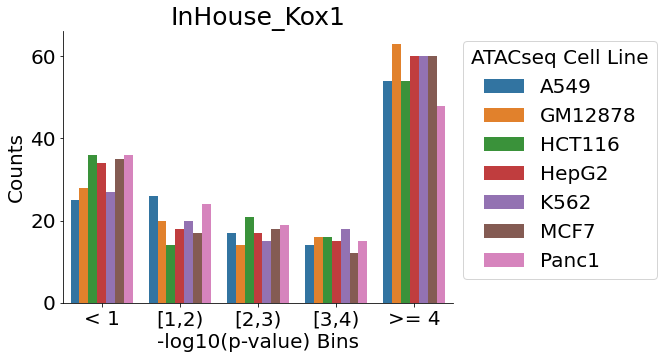

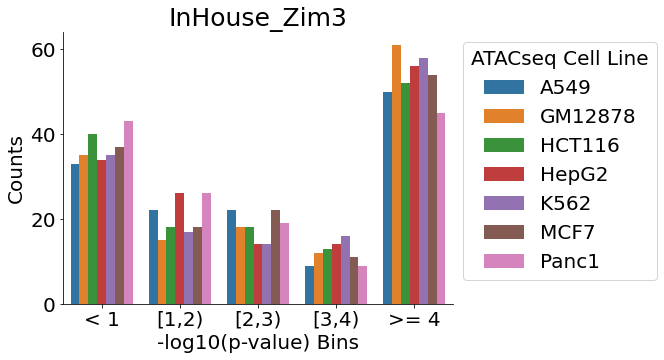

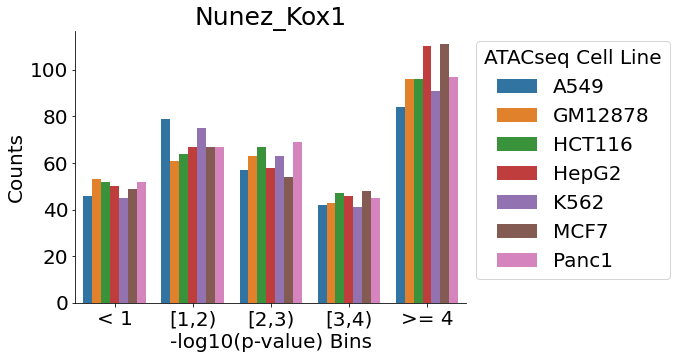

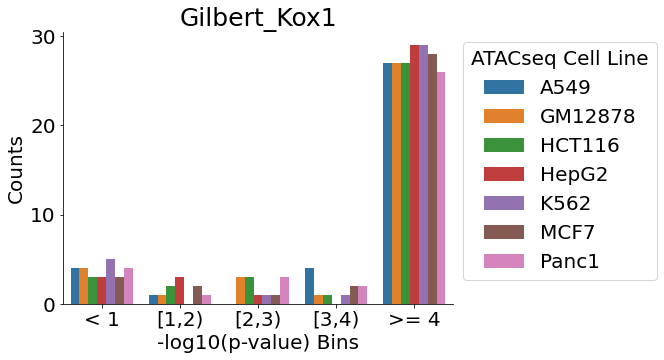

In [24]:
allDataCount = pd.DataFrame()
for dataset in results_df.DataSetID.unique():
    select_pval = results_df[results_df.DataSetID == dataset].copy()
    #select_pval = select_pval.groupby('gene').filter(lambda g: len(g) == 7)
    select_pval['-log10(pval)'] = -np.log10(select_pval['pval'])
    select_pval = categorize_pval(select_pval)
    select_count = pd.DataFrame(select_pval.groupby(['-log10(pval) bins', 'ATACseq']).size().reset_index(name='counts'))
    select_count['DataSetID'] = dataset
    allDataCount = pd.concat([allDataCount, select_count])
    chip_graph(select_count, dataset)

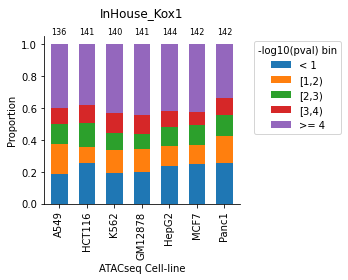

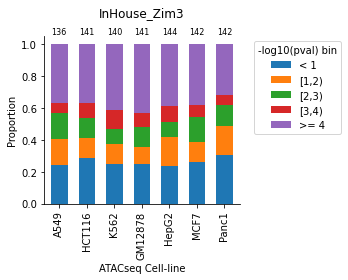

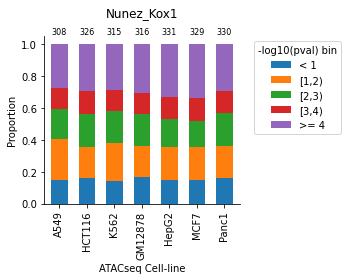

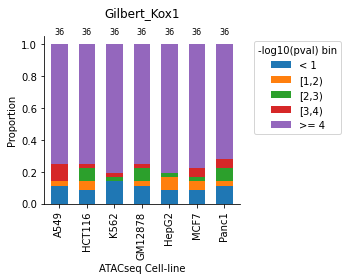

In [25]:
for selectData in allDataCount['DataSetID'].unique():
    select_count = allDataCount[allDataCount.DataSetID == selectData].copy()

    grouped_df = select_count.groupby(['-log10(pval) bins', 'ATACseq'])['counts'].sum().unstack().fillna(0)
    grouped_df = grouped_df[['A549',  'HCT116', 'K562', 'GM12878','HepG2', 'MCF7', 'Panc1']]
    # Calculate percentages
    grouped_df_percentage = grouped_df.transpose().divide(grouped_df.sum(axis=0), axis=0)
    grouped_df_percentage = grouped_df_percentage[['< 1','[1,2)',  '[2,3)','[3,4)','>= 4']]
    # Plotting
    fig, ax = plt.subplots(figsize=(5, 4))

    grouped_df_percentage.plot(kind='bar', stacked=True, ax=ax, width=0.6)

    
     # Add percentages to the bars and the total count
    for i in range(grouped_df_percentage.shape[0]):
        total = 0
        totalCount = grouped_df.iloc[:, i].sum()  # Calculate the total count for each stack
        # Add total count text on top of each stack
        ax.text(i, 1.05, f'{int(totalCount)}', ha='center', va='bottom', fontsize=8, fontweight='light', color='black')

    plt.ylabel('Proportion')
    plt.xlabel('ATACseq Cell-line')
    plt.title(selectData,pad =20)
    plt.legend(title='-log10(pval) bin', bbox_to_anchor=(1.05, 1), loc='upper left')
    sns.despine()
    plt.tight_layout()
    plt.show()